In [ ]:
### Notebook to reformat data from old codebase into new codebase formats

/accounts/projects/sewonm/prasann/.conda/envs/scaling2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
from datasets import Dataset, DatasetDict, concatenate_datasets
from setretrieval.utils.utils import pickload, pickdump
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
import random
from datasets import Dataset, DatasetDict

/accounts/projects/sewonm/prasann/.conda/envs/scaling2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# convert science / gutenberg data into retrieval training examples (use first 27k for train rest for eval)
sciset = Dataset.load_from_disk("../propercache/data/datastores/fullabstractset10k_heldout_0_10000_questions")
gutset = Dataset.load_from_disk("../propercache/data/datastores/gutenberg_train_240k_shuffled_0_10000_questions/")

In [2]:
geminiminiset = Dataset.load_from_disk("../propercache/data/datastores/wikipedia_docs_1.5M_0_100000_gemini-2.5-flash-lite_questions")

In [3]:
geminiminiset[0]

{'text': 'Tomás Mascarenhas Lemos Reymão Nogueira (born 14 July 1998) is a Portuguese professional footballer who plays as a midfielder for Liga Portugal 2 club Leixões. As a youth player, he spent time at clubs such as Sporting CP, Chelsea, Wolverhampton Wanderers and Fiorentina.',
 'questions': ['* What discusses the early developmental stages of individuals before reaching peak professional performance?',
  '* What addresses the transitions and movements of individuals between different organizations?',
  '* What describes the professional roles and current affiliations of individuals within a specific field?'],
 'cost': 6.3e-05}

In [4]:
def preproc_questions(a):
    return a.replace("*", "").strip()

def qdata_to_rettrain(qdata, testsplit=0.9):
    newdata = []
    allchunks = list(qdata['text'])
    for i, qdata in enumerate(qdata):
        for q in qdata['questions']:
            while True:
                neg = random.choice(allchunks)
                if neg != qdata['text']:
                    break
            newdata.append({
                'query': preproc_questions(q),
                'positive': qdata['text'],
                'negative': neg
            })
    return DatasetDict({
        'train': Dataset.from_list(newdata[:int(len(newdata) * testsplit)]),
        'test': Dataset.from_list(newdata[int(len(newdata) * testsplit):])
    })

# scirettrain = qdata_to_rettrain(sciset)
# gutrettrain = qdata_to_rettrain(gutset)
geminiminisettrain10k = qdata_to_rettrain(geminiminiset.select(range(10000)))
geminiminisettrainfull = qdata_to_rettrain(geminiminiset, testsplit=0.99)

In [6]:
# scirettrain.save_to_disk("../propercache/data/colbert_training/gemini_abstracttrain")
# gutrettrain.save_to_disk("../propercache/data/colbert_training/gemini_gutenbergtrain")
geminiminisettrain10k.save_to_disk("../propercache/data/colbert_training/wiki_gemini_mini_train_10k")
geminiminisettrainfull.save_to_disk("../propercache/data/colbert_training/wiki_gemini_mini_train_full")

Saving the dataset (1/1 shards): 100%|██████████| 3000/3000 [00:00<00:00, 124750.03 examples/s]


In [14]:
scirettrain['train'][5]

{'query': 'What are passages that explore the relationship between perturbative approaches and effective field theories in modeling complex dynamics?',
 'positive': 'Title: Perturbation theory, effective field theory, and oscillations in the power spectrum Abstract: We explore the relationship between the nonlinear matter power spectrum and the various Lagrangian and Standard Perturbation Theories (LPT and SPT). We first look at it in the context of one dimensional (1-d) dynamics, where 1LPT is exact at the perturbative level and one can exactly resum the SPT series into the 1LPT power spectrum. Shell crossings lead to non-perturbative effects, and the PT ignorance can be quantified in terms of their ratio, which is also the transfer function squared in the absence of stochasticity. At the order of PT we work, this parametrization is equivalent to the results of effective field theory (EFT), and can thus be expanded in terms of the same parameters. We find that its radius of convergenc

In [40]:
def get_coldata_positives(startindex, endindex):
    ds = pickload(f"../propercache/cache/gendata/passagesearchtrain_v2_{startindex}_{endindex}_0.pkl")
    coldata = DatasetDict.load_from_disk("../propercache/data/colbert_training/gemini_ntrain_ptest")['train'].select(range(startindex, endindex))
    queries = [row['query'] for row in coldata]
    dstore = Dataset.load_from_disk("../propercache/data/datastores/wikipedia_docs_10k_decont")
    dtexts = [d['text'] for d in dstore]
    positives = []
    for preds in ds:
        positives.append([dtexts[i] for i in range(len(preds)) if preds[i]])
    print("Number of questions with >1 positives", sum([len(p) > 1 for p in positives]))
    print("Number of questions with 1 positives", sum([len(p) == 1 for p in positives]))
    posflat = [item for sublist in positives for item in sublist]
    newdata = []
    for i in range(len(positives)):
        for j in range(len(positives[i])):
            # get a negative
            while True:
                neg = random.choice(posflat)
                if neg not in positives[i]:
                    break
            newdata.append({
                "query": queries[i],
                "positive": positives[i][j],
                "negative": neg
            })
    return newdata

ranges = [[0, 1500], [1500, 3000], [3000, 4500]]
alldata = []
for start, end in ranges:
    alldata.extend(get_coldata_positives(start, end))
alldata = Dataset.from_list(alldata)

Number of questions with >1 positives 526
Number of questions with 1 positives 281
Number of questions with >1 positives 550
Number of questions with 1 positives 285
Number of questions with >1 positives 43
Number of questions with 1 positives 25


In [37]:
olddata = DatasetDict.load_from_disk("../propercache/data/colbert_training/gemini_ntrain_ptest")
olddata['train'] = alldata
olddata.save_to_disk("../propercache/data/colbert_training/gemini_multipostrain_ptest")

Saving the dataset (1/1 shards): 100%|██████████| 2993/2993 [00:00<00:00, 34605.57 examples/s]


In [39]:
olddata = DatasetDict.load_from_disk("../propercache/data/colbert_training/gemini_ntrain_ptest")
olddata['train'] = olddata['train'].select(range(len(olddata['train']) - len(alldata)))
olddata['train'] = concatenate_datasets([olddata['train'], alldata])
olddata.save_to_disk("../propercache/data/colbert_training/gemini_multisingleposmix_ptest")

Saving the dataset (1/1 shards): 100%|██████████| 2993/2993 [00:00<00:00, 49574.89 examples/s]


In [32]:
initdata = get_coldata_positives(1500, 3000)

Number of questions with >1 positives 550


In [33]:
initdata = get_coldata_positives(3000, 4500)

Number of questions with >1 positives 43


In [24]:
newdata = Dataset.from_list(newdata)

In [26]:
newdata

Dataset({
    features: ['query', 'positive', 'negative'],
    num_rows: 6727
})

In [21]:
coldata

Dataset({
    features: ['query', 'positive', 'negative'],
    num_rows: 1500
})

In [ ]:
# load 


In [14]:
coldata['train']

Dataset({
    features: ['query', 'positive', 'negative'],
    num_rows: 27000
})

In [7]:
len(ds)

1500

In [14]:
dataset = Dataset.load_from_disk("../propercache/data/datastores/wikipedia_docs_15k")

In [23]:
datasetdecont = Dataset.load_from_disk("../propercache/data/datastores/wikipedia_docs_150k").select(range(10000))
decontset = set([d['text'] for d in datasetdecont])

In [24]:
datasetdecont.save_to_disk("../propercache/data/datastores/wikipedia_docs_10k_decont")

Saving the dataset (1/1 shards): 100%|██████████| 10000/10000 [00:00<00:00, 97713.98 examples/s]


In [7]:
testdata = Dataset.load_from_disk("../propercache/data/evalsets/settest_v1")

In [ ]:
allpchunks = []
for t in testdata:
    allpchunks.extend(t['pos_chunks'])
allpchunks = list(set(allpchunks))

In [11]:
docsset = set([d['text'] for d in dataset])

In [18]:
assert all([d in docsset for d in allpchunks])
assert all([d not in decontset for d in allpchunks])
# get some code to convert from output files, document to retrieval training examples

In [5]:
dataset

Dataset({
    features: ['text', 'id', 'wc'],
    num_rows: 1575261
})

In [ ]:
# get some code to convert from output files, document to retrieval training examples
startdocs = pickload("propercache/data/datastores/wikiped")

In [43]:
fifteen = Dataset.load_from_disk("../propercache/data/datastores/wikipedia_docs_15k")

In [44]:
testdata = Dataset.load_from_disk("../propercache/data/evalsets/settest_v1")

In [45]:
paraphrased = Dataset.from_json("../propercache/data/colbert_training/gemini_indoc_test_filtered.jsonl")

Generating train split: 2993 examples [00:00, 16354.50 examples/s]


In [46]:
allquestions = set([p['query'] for p in paraphrased])

In [47]:
assert all([q['question'] in allquestions for q in testdata])

In [48]:
newtest = []
for t in tqdm(testdata, desc="Paraphrasing queries"):
    for p in paraphrased:
        if t['question'] == p['query']:
            if p['category'] == "Stylistic":
                continue
            newtest.append(t)
            newtest[-1]['question'] = p['rephrased_query']
            newtest[-1]['category'] = p['category']
            break
# testdata.save_to_disk("../propercache/data/evalsets/settest_v1_paraphrased")


Paraphrasing queries: 100%|██████████| 572/572 [00:11<00:00, 51.93it/s]


In [ ]:
# Dataset.from_list(newtest).save_to_disk("../propercache/data/evalsets/settest_v1_paraphrased")

Saving the dataset (1/1 shards): 100%|██████████| 533/533 [00:00<00:00, 2494.29 examples/s]


In [34]:
newtest[0]

{'question': 'What projects have been revived after political suppression?',
 'pos_chunks': ['The Kharkiv School of Photography (KSOP) () is a Ukrainian artistic photography movement. It was created in opposition to the Soviet socialist realism art style, which reigned from 1934 until the 1980s. KSOP started to form in the 1960s when artistic photography revived in Kharkiv during the period of the Khrushchev Thaw. KSOP\'s official formation as a non-conformist underground movement was denoted by the establishment of a group by Kharkiv photographers named the Vremia Group 1971; its foundation is considered the sign of the revival of modernist art in Kharkiv.\n\t\nThe Vremia Group built upon avant-garde traditions and brought socialist realism dogmas into play. They are known for extreme experimentations with photography techniques and methods and are credited for inventing and developing a number of them. One of their signature aesthetic inventions is the "blow theory" (or "the theory o

In [41]:
print(Counter([t['category'] for t in newtest]))

Counter({'Abstract': 312, 'Semi-Specific': 177, 'Specific': 44, 'Stylistic': 39})


In [38]:
cats = ['Abstract', "Semi-Specific", "Specific", "Stylistic"]
clens = {c: [] for c in cats}
for t in newtest:
    clens[t['category']].append(min(t['numposchunks'], 100))

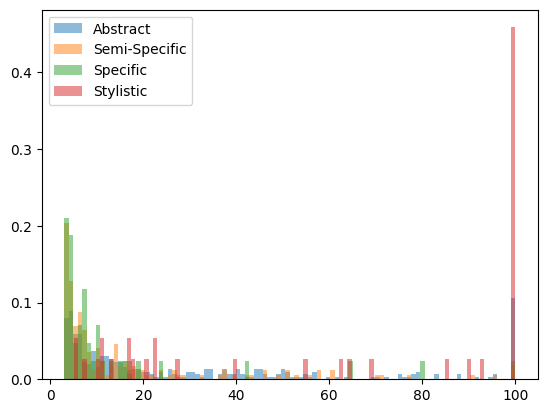

In [40]:
for c in clens:
    plt.hist(clens[c], bins=100, density=True, alpha=0.5, label=c)
plt.legend()
plt.show()


In [6]:
smallset = fifteen.select(range(10))
smallset.save_to_disk("../data/datastores/wikipedia_docs_debug10")

Saving the dataset (1/1 shards): 100%|██████████| 10/10 [00:00<00:00, 1679.27 examples/s]


In [53]:
wdatafull = pickload("../data/datastores/wikipedia_docs_8chunksparagraph.pkl")
wflat = [item for sublist in wdatafull for item in sublist]

In [55]:
weirdcount = 0
for w in wflat:
    w['text'] = str(w['text'])
    if type(w['id']) != int:
        w['id'] = -1
        weirdcount += 1
print(f"weirdcount: {weirdcount}")

weirdcount: 0


In [ ]:
f2ind = {row['text']: i for i, row in enumerate(wflat)}
wfset = set(row['text'] for row in wflat)

In [61]:
dset12k = Dataset.from_list(wflat[62000:77000])

In [ ]:
dset12k.save_to_disk("../data/datastores/wikipedia_docs_15k")

In [62]:
dset12k.save_to_disk("../data/datastores/wikipedia_docs_15k")
# Dataset.from_list(wflat).save_to_disk("../data/datastores/wikipedia_docs_150k")

Saving the dataset (1/1 shards): 100%|██████████| 15000/15000 [00:00<00:00, 100512.93 examples/s]


In [ ]:
# did the full one in the original notebook, TODO can put this stuff together later into smth reproducible

In [ ]:
qdata = Dataset.load_from_disk("../data/evalsets/distractor_queries_settestdata")
allpos = [r['pos_chunks'] for r in qdata]
allposflat = [item for sublist in allpos for item in sublist]

In [34]:
allinds = [f2ind[item] for item in set(allposflat)]

(array([135., 146., 161., 157., 171., 176., 142., 169., 176., 161., 157.,
        139., 166., 172., 142., 154., 164., 164., 153., 138., 158., 166.,
        153., 157., 159., 145., 139., 157., 172., 162., 167., 146., 161.,
        151., 168., 161., 163., 184., 149., 163., 156., 170., 160., 159.,
        156., 151., 158., 152.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([65036.  , 65244.74, 65453.48, 65662.22, 65870.96, 66079.7 ,
        66288.44, 66497.18, 66705.92, 66914.66, 67123.4 , 67332.14,
        67540.88, 67749.62, 67958.36, 68167.1 , 68375.84, 68584.58,
        68793.32, 69002.06, 69210.8 , 69419.54, 69628.28, 69837.02,
        70045.76, 70254.5 , 70463.24, 70671.98

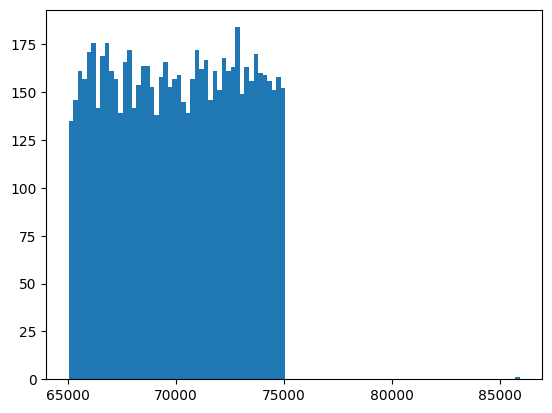

In [35]:
plt.hist(allinds, bins=100)

In [8]:
qdset = Dataset.from_list(qdata)

In [9]:
qdset[0]

{'question': 'Which passage describes a project being revived after a period of political suppression?',
 'goldind': [1354, 1360, 5388, 7755],
 'pos_chunks': ['The Kharkiv School of Photography (KSOP) () is a Ukrainian artistic photography movement. It was created in opposition to the Soviet socialist realism art style, which reigned from 1934 until the 1980s. KSOP started to form in the 1960s when artistic photography revived in Kharkiv during the period of the Khrushchev Thaw. KSOP\'s official formation as a non-conformist underground movement was denoted by the establishment of a group by Kharkiv photographers named the Vremia Group 1971; its foundation is considered the sign of the revival of modernist art in Kharkiv.\n\t\nThe Vremia Group built upon avant-garde traditions and brought socialist realism dogmas into play. They are known for extreme experimentations with photography techniques and methods and are credited for inventing and developing a number of them. One of their sig

In [10]:
qdset = qdset.remove_columns(["goldind", "chunks"])

In [11]:
qdset.save_to_disk("../data/evalsets/distractor_queries_settestdata")

Saving the dataset (1/1 shards): 100%|██████████| 572/572 [00:00<00:00, 1983.24 examples/s]


In [12]:
# for initial gemini indoc data, reformat to have format [query, positive, negative], be broken into train / test split
testdata = Dataset.from_json("../data/colbert_training/gemini_indoc_test.jsonl")
traindata = Dataset.from_json("../data/colbert_training/gemini_indoc_train.jsonl")
testdatafilt = Dataset.from_json("../data/colbert_training/gemini_indoc_test_filtered.jsonl")
traindatafilt = Dataset.from_json("../data/colbert_training/gemini_indoc_train_filtered.jsonl")

In [13]:
testdatafilt

Dataset({
    features: ['query', 'pos', 'neg', 'category', 'rephrased_query'],
    num_rows: 2993
})

In [14]:
def reformat_data(row):
    return {
        "query": row['rephrased_query'] if "rephrased_query" in row else row["query"],
        "positive": row["pos"][0],
        "negative": row["neg"][0]
    }

testdata = testdata.map(reformat_data).remove_columns(["pos", "neg", "posind"])
traindata = traindata.map(reformat_data).remove_columns(["pos", "neg", "posind"])
testdatafilt = testdatafilt.map(reformat_data).remove_columns(["pos", "neg", "category", "rephrased_query"])
traindatafilt = traindatafilt.map(reformat_data).remove_columns(["pos", "neg", "category", "rephrased_query"])

Map:   0%|          | 0/27000 [00:00<?, ? examples/s]

Map: 100%|██████████| 27000/27000 [00:03<00:00, 8432.27 examples/s] 


In [18]:
DatasetDict({"train": traindata, "test": testdata}).save_to_disk("../data/colbert_training/gemini_datav1")
DatasetDict({"train": traindata, "test": testdatafilt}).save_to_disk("../data/colbert_training/gemini_ntrain_ptest")
DatasetDict({"train": traindatafilt, "test": testdatafilt}).save_to_disk("../data/colbert_training/gemini_ptrain_ptest")

Saving the dataset (1/1 shards): 100%|██████████| 2993/2993 [00:00<00:00, 49833.88 examples/s]


In [28]:
assert all(type(x) == str for x in testdata["negative"])